In [47]:
# import what we need
library(dplyr)
library(boot)
library(pscl)
library(MASS)
library(ggplot2)
library(ggpubr)
library(lme4)
library(AER)
library(cowplot)

In [5]:
wound_data <- read.csv("wounddata.csv")
str(wound_data)

'data.frame':	80 obs. of  6 variables:
 $ bee_code      : chr  "Wound_C_H1_1" "Wound_C_H1_2" "Wound_C_H1_3" "Wound_C_H1_4" ...
 $ treatment     : chr  "Control" "Control" "Control" "Control" ...
 $ hive          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ susceptibility: int  0 0 0 0 1 0 0 0 0 1 ...
 $ spores        : int  0 0 0 0 5000 0 0 0 0 210000 ...
 $ divided_100   : int  0 0 0 0 50 0 0 0 0 2100 ...


In [7]:
wound_data$hive <- factor(wound_data$hive)
wound_data$treatment <- factor(wound_data$treatment)
head(wound_data)
# susceptibility is a binary variable which simply states presence/absence of spores

,bee_code,treatment,hive,susceptibility,spores,divided_100
,<chr>,<fct>,<fct>,<int>,<int>,<int>
1,Wound_C_H1_1,Control,1,0,0,0
2,Wound_C_H1_2,Control,1,0,0,0
3,Wound_C_H1_3,Control,1,0,0,0
4,Wound_C_H1_4,Control,1,0,0,0
5,Wound_C_H1_5,Control,1,1,5000,50
6,Wound_C_H1_6,Control,1,0,0,0


## 1. Inspect the data structure

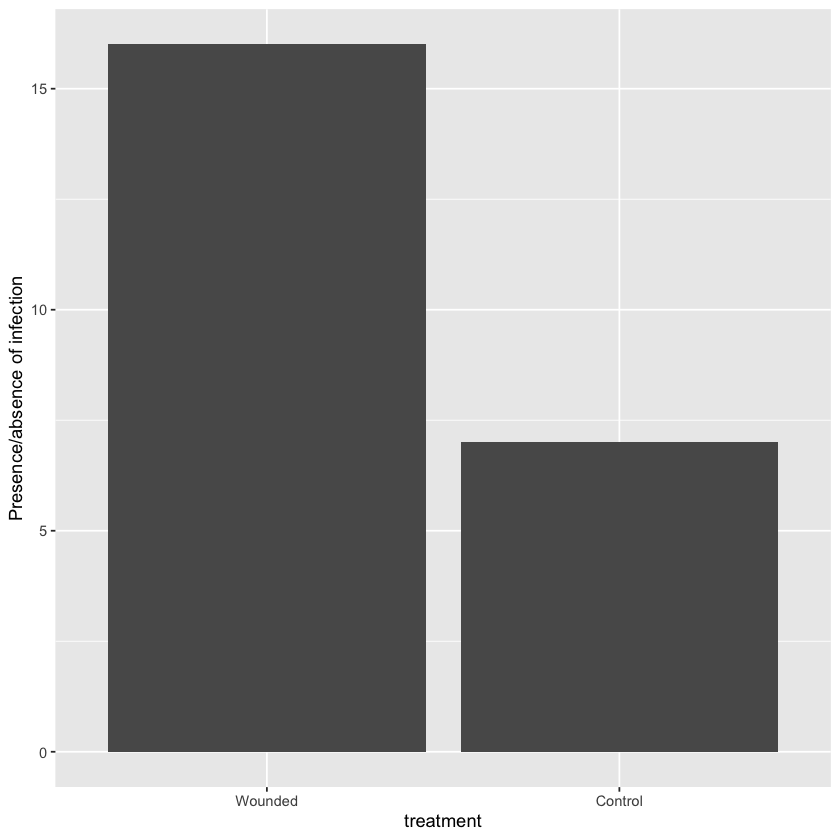

In [9]:
wound.susceptbar <- ggplot(data = wound_data, aes(x=treatment, y=susceptibility)) + 
geom_bar(stat = "identity") + ylab("Presence/absence of infection")
wound.susceptbar
# wounded bees appear to have a clearly higher number of bees with spores present

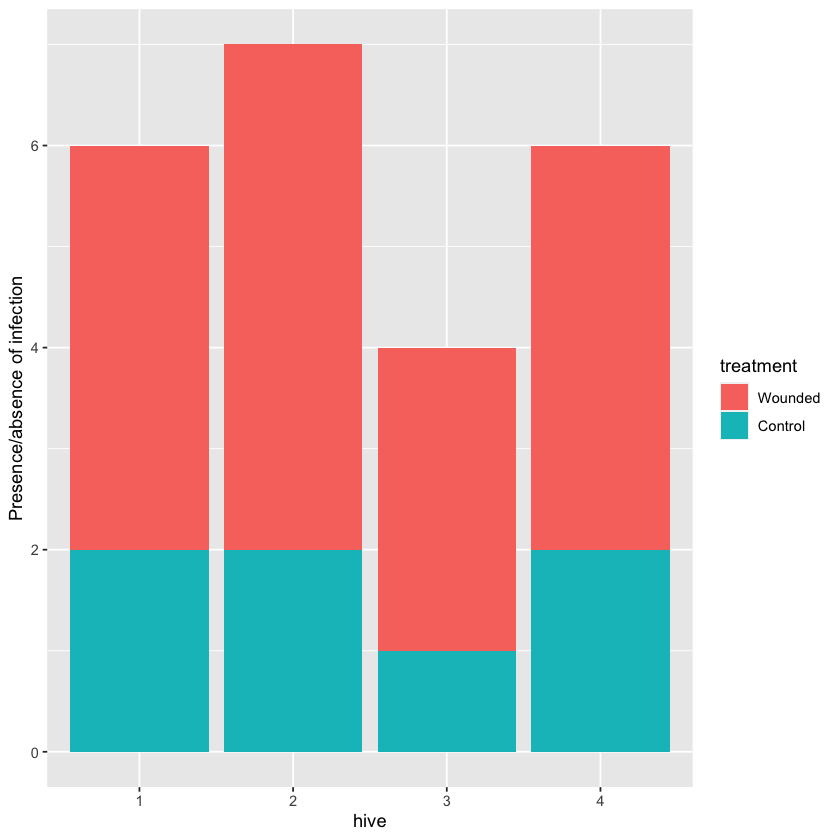

In [10]:
# see if there is a hive effect on susceptibility
wound.hive.susceptbar <- ggplot(data = wound_data, aes(x=hive, y=susceptibility, fill = treatment)) + 
geom_bar(stat = "identity") + ylab("Presence/absence of infection")
wound.hive.susceptbar

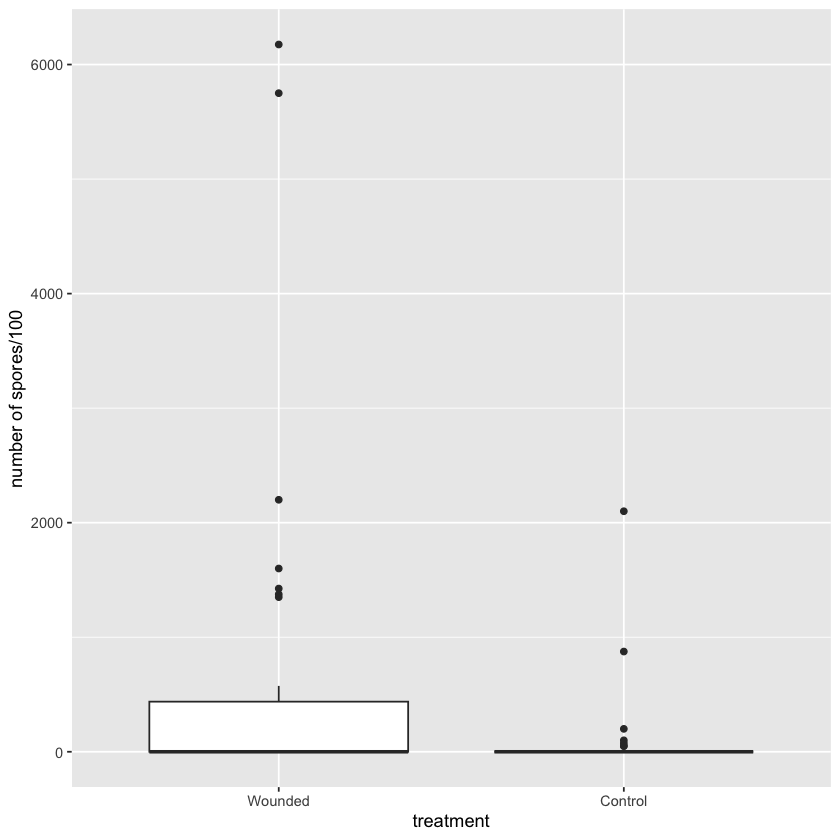

In [12]:
# see how wounding impacted spores
wound.spores <- ggplot(data = wound_data, aes(x=treatment, y=divided_100)) + geom_boxplot() + ylab("number of spores/100")
wound.spores

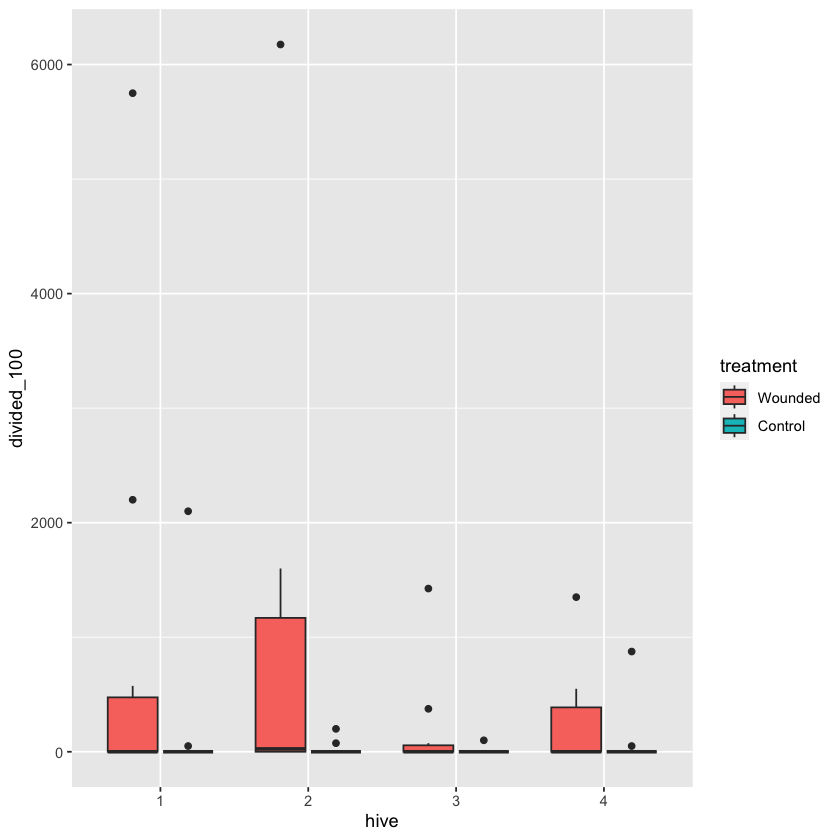

In [13]:
wound.hive.boxplot <- ggplot(data = wound_data, aes(x=hive, y=divided_100, fill = treatment)) + geom_boxplot()
wound.hive.boxplot
# shows that Hive 2 had a lot of spores compared to others and that hive 3 had very few spores
# could be indicative of a hive effect here

## 2. Selecting a model

### 2a. Modelling susceptibility of infection

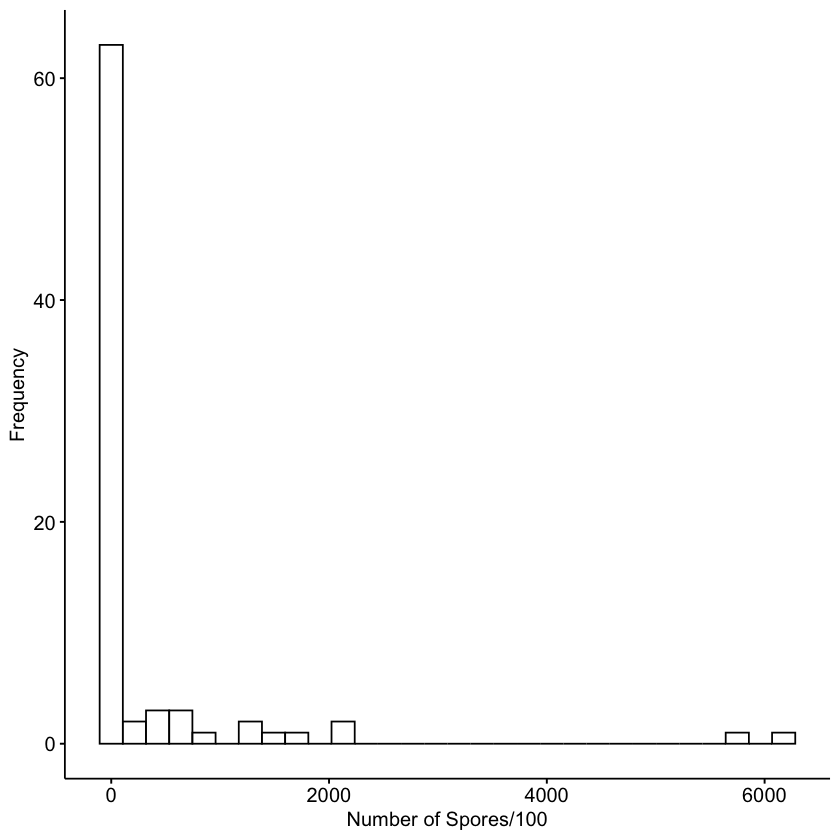

In [17]:
wound.dist.hist <- gghistogram(wound_data, x = "divided_100", y = "..count..", palette = 'npg', 
                              xlab = "Number of Spores/100", ylab = "Frequency", bins = 30)
wound.dist.hist
# hugely zero inflated because lots of spores, so will do a two part model, same logistic regression
# to examine chance of no spores as before. But also will run a zero-truncated madel too where I only examine
# spore on the bees which have infections present 

In [22]:
# Logistic regression
wounding.susceptibility <- glmer(susceptibility ~ treatment + (1|hive), data = wound_data,
                         family = binomial)
isSingular(wounding.susceptibility)

boundary (singular) fit: see help('isSingular')



[1] TRUE

In [27]:
# with random effect of Hive removed
wounding.susceptibility.nohive <- glm(susceptibility ~ treatment, data = wound_data,
                              family = binomial)
# no singularity warning
summary(wounding.susceptibility.nohive)


Call:
glm(formula = susceptibility ~ treatment, family = binomial, 
    data = wound_data)

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.5506     0.4161  -3.726 0.000194 ***
treatmentWounded   1.1451     0.5266   2.175 0.029667 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 95.984  on 79  degrees of freedom
Residual deviance: 90.939  on 78  degrees of freedom
AIC: 94.939

Number of Fisher Scoring iterations: 4


In [31]:
Anova(wounding.susceptibility.nohive)
# Likelihood ratio chi-sq test shows that wounding.prevalence2 is signficantly better at explaining data
# than null model. So wounding made bees more susceptible to infectio

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
treatment,5.044635,1,0.02470232


### 2b. Modelling spore counts

In [32]:
# I will run the spore model on all bees that showed spores
# So the model will show "of the bees that contract nosema in very small dose, does wounding 
# change the number of spores"
wound.data.nozero <- wound_data %>% filter(divided_100 !=0)

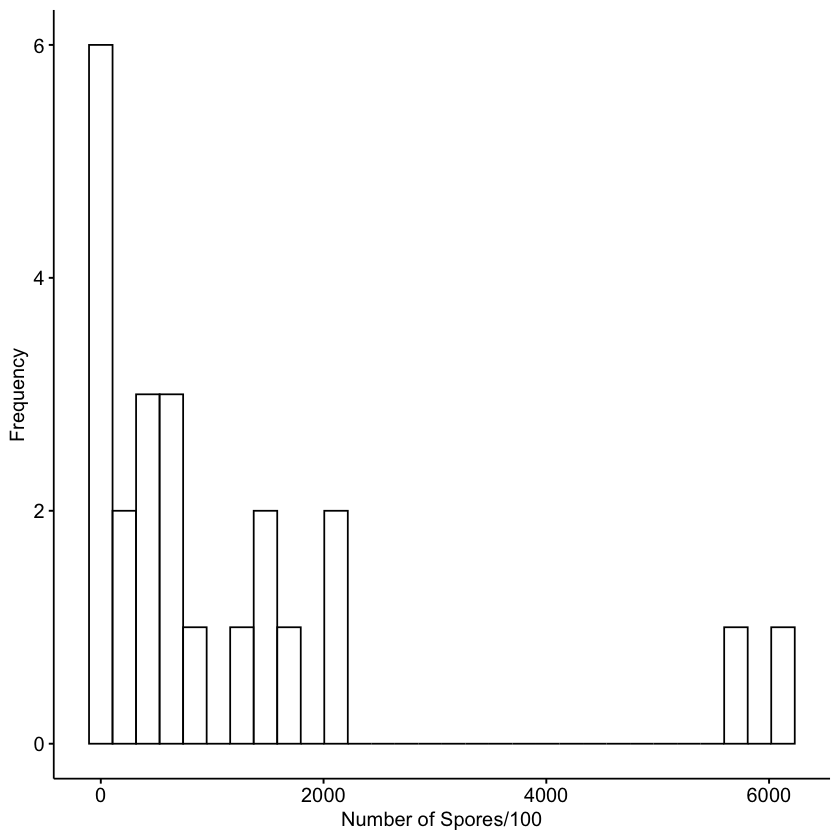

In [34]:
# this will give us a data frame with zeros removed, but very few observations (6 for Control and 16 for Treatment)
wound.nozero.dist.hist <- gghistogram(wound.data.nozero, x = "divided_100", y = "..count..", palette = 'npg', xlab = "Number of Spores/100", ylab = "Frequency", bins = 30)
wound.nozero.dist.hist

In [37]:
# NB model with random effect of hive
nozero.wound.global <- glmer.nb(divided_100 ~ treatment + (1|hive), data = wound.data.nozero)
isSingular(nozero.wound.global)

boundary (singular) fit: see help('isSingular')




[1] TRUE

In [39]:
# negligable hive effect, let's remove it 
nozero.wound.nohive <- glm.nb(divided_100 ~ treatment, data = wound.data.nozero)
summary(nozero.wound.nohive)


Call:
glm.nb(formula = divided_100 ~ treatment, data = wound.data.nozero, 
    init.theta = 0.7298464959, link = log)

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)        6.2002     0.4427  14.004   <2e-16 ***
treatmentWounded   1.0694     0.5308   2.015   0.0439 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.7298) family taken to be 1)

    Null deviance: 31.038  on 22  degrees of freedom
Residual deviance: 27.602  on 21  degrees of freedom
AIC: 369.76

Number of Fisher Scoring iterations: 1


              Theta:  0.730 
          Std. Err.:  0.184 

 2 x log-likelihood:  -363.759 

In [40]:
Anova(nozero.wound.nohive)
# model is non-significant from null model, probably because we have so few replicates

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
treatment,3.436843,1,0.06375739


In [41]:
# will now go for a Mann-Whitney test, to simply test for a significant difference between the spore levels.
mann.control.dist <- wound.data.nozero %>% filter(treatment != "Wounded")
mann.wounded.dist <- wound.data.nozero %>% filter(treatment != "Control")
wilcox.test(mann.control.dist$divided_100, mann.wounded.dist$divided_100, mu=0, alt="two.sided", conf.int = T,
            conf.level = 0.95)

Warning message in wilcox.test.default(mann.control.dist$divided_100, mann.wounded.dist$divided_100, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mann.control.dist$divided_100, mann.wounded.dist$divided_100, :
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  mann.control.dist$divided_100 and mann.wounded.dist$divided_100
W = 29.5, p-value = 0.0819
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -1350.00003    25.00002
sample estimates:
difference in location 
             -415.2375 


In [42]:
# not a signifcant difference in the medians of the two groups, with such a small sample s=size for control, the test
# loses power to make an accurate predicition (P = 0.082; Mann-Whitney U test)

## 3. Plotting our findings

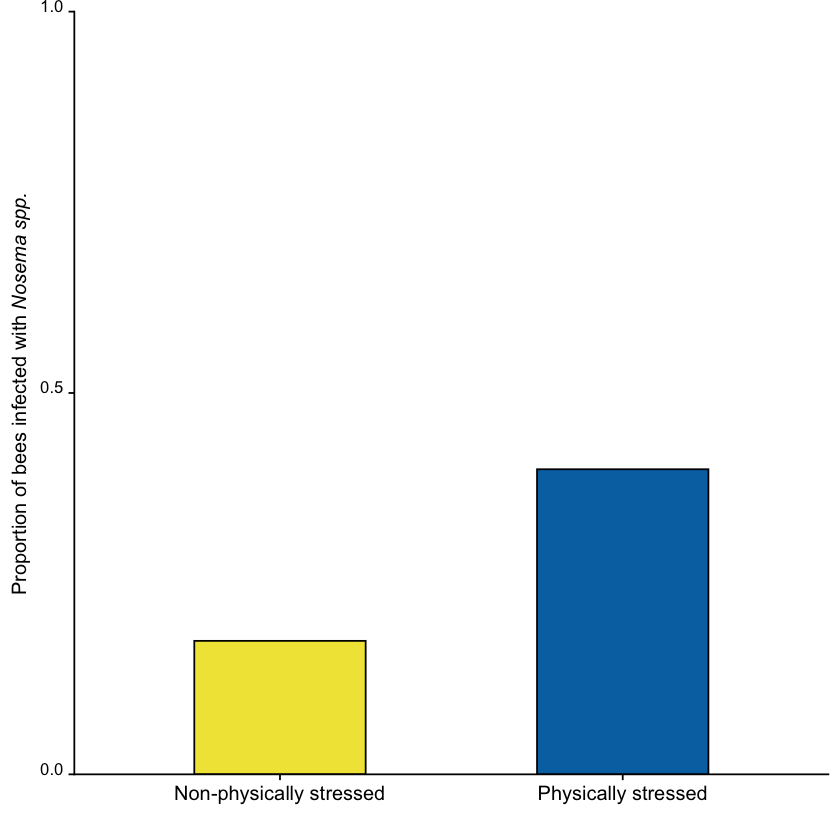

In [51]:
wounding.susceptibility.barchart <- ggplot(wound_data, aes(x = treatment, y = susceptibility/40, fill = treatment)) + 
  stat_summary(fun = sum, geom = "bar", colour="black", width = 0.5) + scale_fill_manual(values =  c("#F0E442", "#0072B2")) + 
  theme_cowplot() + ylab("Proportion of bees infected with"~italic("Nosema spp.")) + xlab("") + 
  scale_x_discrete(labels = c("Non-physically stressed", "Physically stressed")) + theme(axis.text.x = element_text(face = "plain",size = 12,vjust = 0.99, hjust = 0.5, colour = "black"), axis.text.y = element_text(face="plain", size = 10, angle = 0, vjust = 0.0,  hjust = 0.5, colour = "black")) + 
  theme(text = element_text(size=12)) + scale_y_continuous(limits = c(0,1), expand = c(0,0), breaks = seq(0,1, by = 0.5))
wounding.susceptibility.barchart + theme(legend.position = "none")

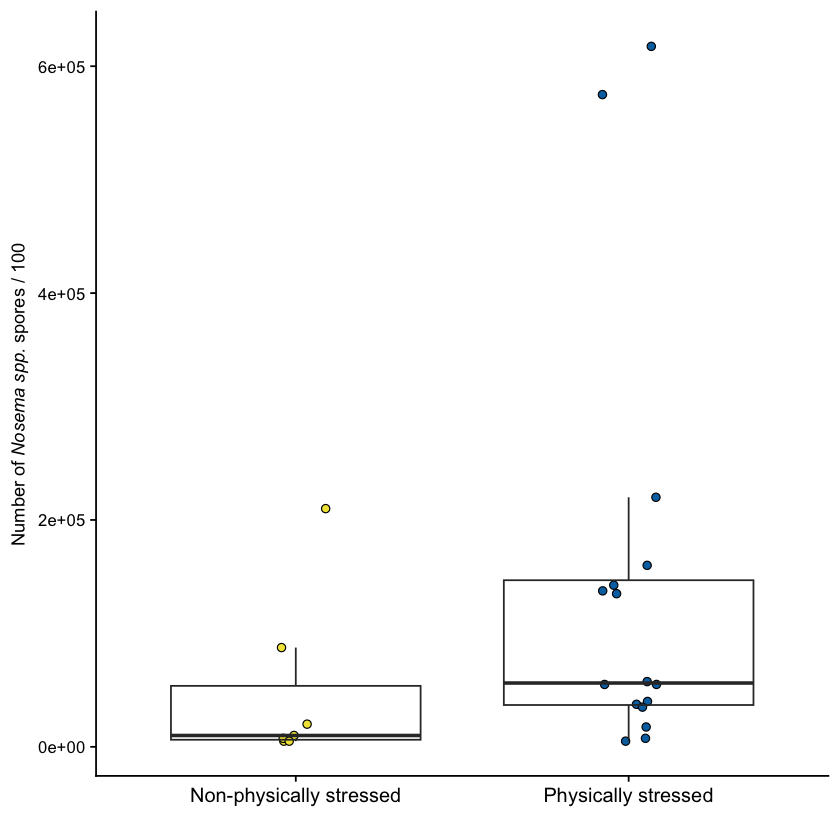

In [53]:
w <- ggplot(wound.data.nozero, aes(x=treatment, y=spores, fill=treatment))
wound.spores.boxplot <- w + geom_point(aes(fill = treatment), size = 2, shape = 21, position = position_jitterdodge()) + geom_boxplot(position = position_dodge(0.9), alpha = 0) + theme_cowplot() + 
theme(legend.position = "top") + ylab("Number of"~italic("Nosema spp.")~"spores / 100") + 
scale_x_discrete(labels = c("Non-physically stressed", "Physically stressed")) + theme(legend.text=element_text(size=9), legend.title=element_text(size=10)) + 
xlab("") + theme(text = element_text(size=11), axis.text.y = element_text(size = 10)) + scale_fill_manual(values=c("#F0E442", "#0072B2"))
wound.spores.boxplot + theme(legend.position = "none")